In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 80

ng =5

ng_adju = (/ 1 /) 

ng_refs = (/ 2 , 3 /) 

nref =2

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 100 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 720

data w_diffuse
     &     /1.55 , 1.6 , 1.66 , 1.66,
     &     1.8/

data wgt
     &     /0.5 , 0.5 , 0.6 , 0.7,
     &     0.9/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

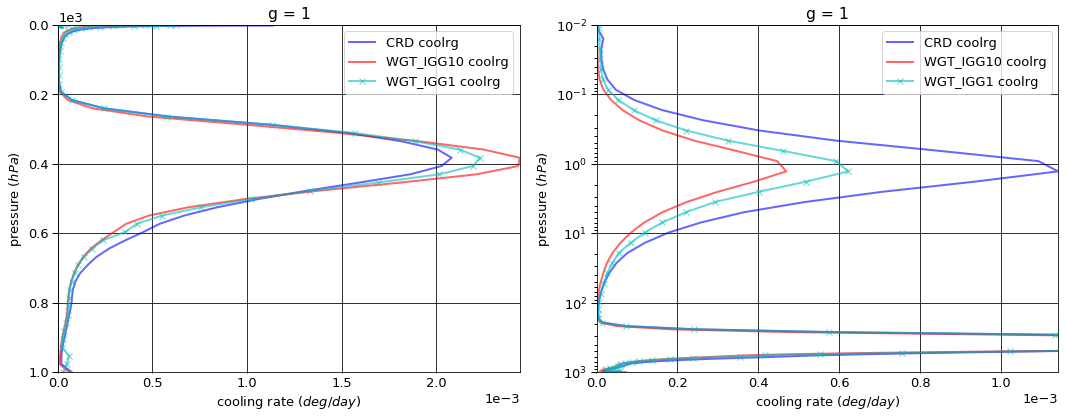

# Figure: cooling rate g-group 2

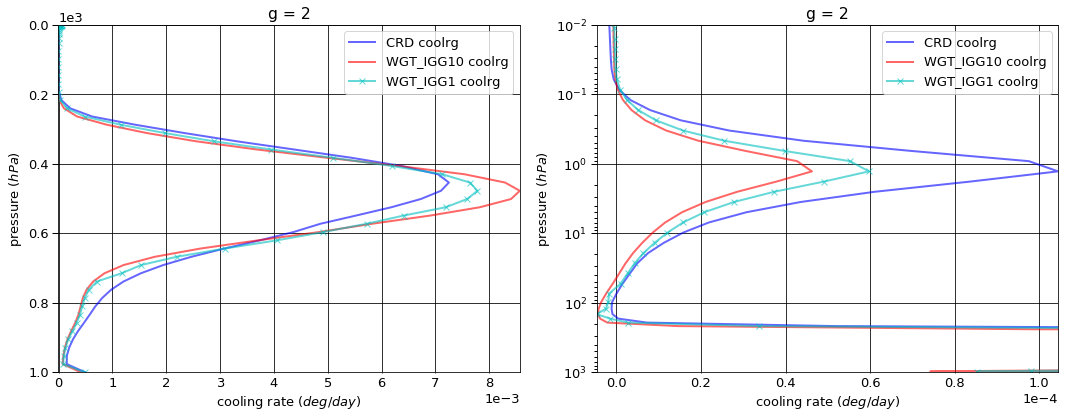

# Figure: cooling rate g-group 3

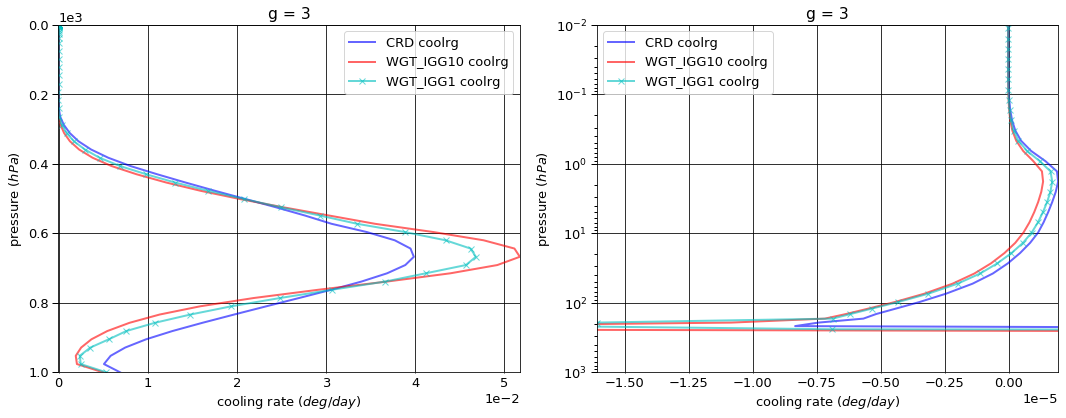

# Figure: cooling rate g-group 4

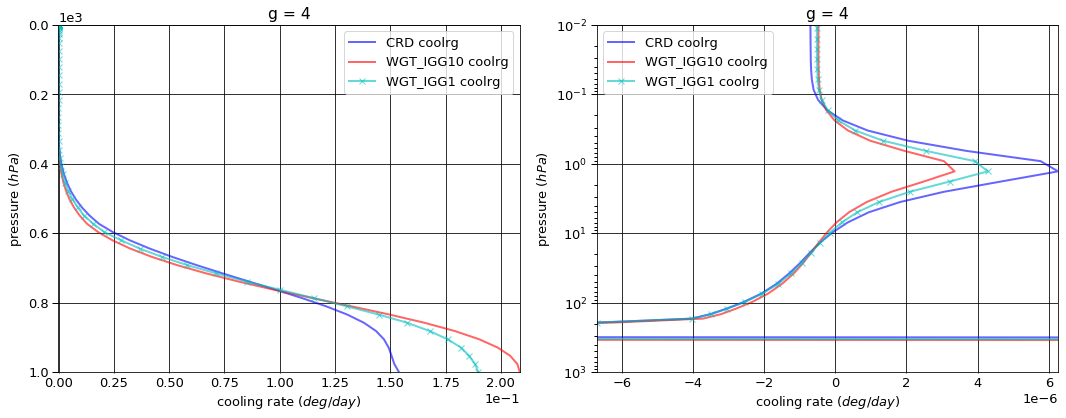

# Figure: cooling rate g-group 5

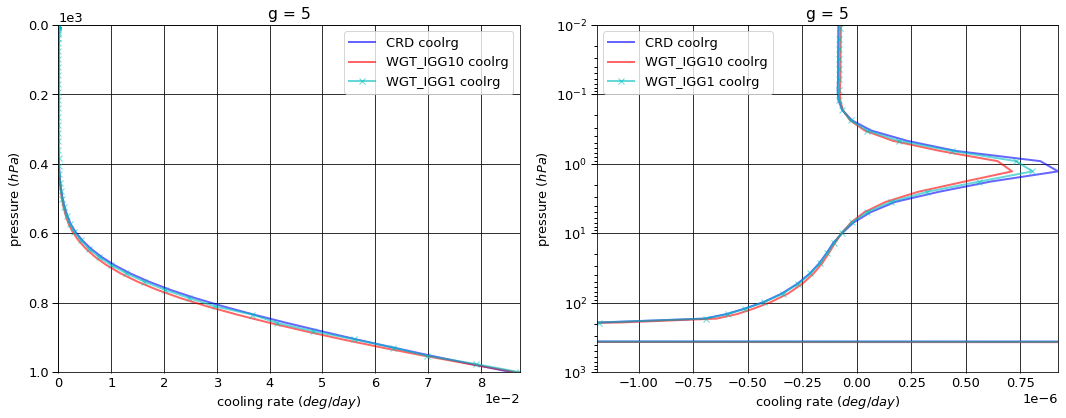

# Figure: cooling rate g-group total

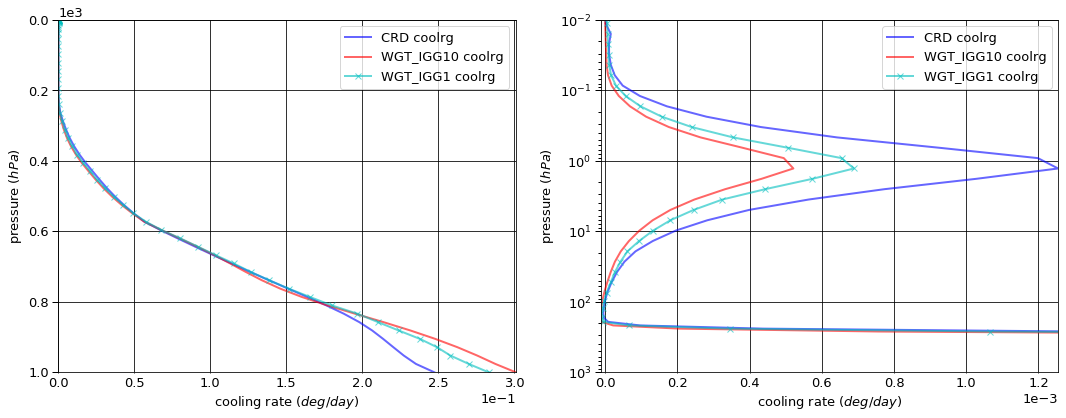

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.061930  0.000000  -0.061930
  1013.0   76     -0.127030  0.126839  -0.000191
2 0.0      1      -0.261662  0.000000  -0.261662
  1013.0   76     -0.458784  0.457245  -0.001539
3 0.0      1      -1.702966  0.000000  -1.702966
  1013.0   76     -2.348585  2.318958  -0.029626
4 0.0      1     -10.060903  0.000000 -10.060903
  1013.0   76    -10.872224  6.248983  -4.623241
5 0.0      1     -18.652642  0.000000 -18.652642
  1013.0   76    -18.830921  1.960610 -16.870311


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.061594  0.000000  -0.061594
  1013.0   76     -0.127030  0.126874  -0.000156
2 0.0      1      -0.262253  0.000000  -0.262253
  1013.0   76     -0.458784  0.457685  -0.001099
3 0.0      1      -1.682619  0.000000  -1.682619
  1013.0   76     -2.348585  2.333026  -0.015559
4 0.0      1     -10.090848  0.000000 -10.090848
  1013.0   76    -10.872224  7.000440  -3.871784
5 0.0      1     -18.670056  0.000000 -18.670056
  1013.0   76    -18.830921  1.848926 -16.981995


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.061266  0.000000  -0.061266
  1013.0   76     -0.127030  0.126956  -0.000074
2 0.0      1      -0.261861  0.000000  -0.261861
  1013.0   76     -0.458784  0.457485  -0.001299
3 0.0      1      -1.685444  0.000000  -1.685444
  1013.0   76     -2.348585  2.330850  -0.017735
4 0.0      1     -10.060627  0.000000 -10.060627
  1013.0   76    -10.872224  6.829912  -4.042311
5 0.0      1     -18.659070  0.000000 -18.659070
  1013.0   76    -18.830921  1.925033 -16.905888


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.362370e-04  0.000000  0.000336
  1013.0   76     0.000000e+00  0.000035  0.000035
2 0.0      1     -5.913200e-04  0.000000 -0.000591
  1013.0   76     0.000000e+00  0.000440  0.000440
3 0.0      1      2.034760e-02  0.000000  0.020348
  1013.0   76     0.000000e+00  0.014067  0.014067
4 0.0      1     -2.994500e-02  0.000000 -0.029945
  1013.0   76     1.776357e-15  0.751457  0.751457
5 0.0      1     -1.741400e-02  0.000000 -0.017414
  1013.0   76     0.000000e+00 -0.111683 -0.111684


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      6.639510e-04  0.000000  0.000664
  1013.0   76     0.000000e+00  0.000117  0.000117
2 0.0      1     -1.994100e-04  0.000000 -0.000199
  1013.0   76     0.000000e+00  0.000240  0.000240
3 0.0      1      1.752190e-02  0.000000  0.017522
  1013.0   76     0.000000e+00  0.011892  0.011892
4 0.0      1      2.760000e-04  0.000000  0.000276
  1013.0   76     1.776357e-15  0.580930  0.580930
5 0.0      1     -6.428000e-03  0.000000 -0.006428
  1013.0   76     0.000000e+00 -0.035576 -0.035577

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.470750e-06
  1001.112500 75     7.407783e-05
2 0.000312    1     -2.321805e-06
  1001.112500 75     4.952728e-04
3 0.000312    1     -1.469197e-08
  1001.112500 75     6.903520e-03
4 0.000312    1     -7.084810e-07
  1001.112500 75     1.539838e-01
5 0.000312    1     -7.930183e-08
  1001.112500 75     8.593193e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -4.459763e-06
  1001.112500 75     5.927896e-05
2 0.000312    1     -1.008121e-06
  1001.112500 75     4.163203e-04
3 0.000312    1     -1.920704e-08
  1001.112500 75     4.976629e-03
4 0.000312    1     -4.726408e-07
  1001.112500 75     2.085931e-01
5 0.000312    1     -6.791811e-08
  1001.112500 75     8.689570e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.215374e-06
  1001.112500 75     2.650718e-05
2 0.000312    1     -9.090771e-07
  1001.112500 75     4.845509e-04
3 0.000312    1     -1.975041e-08
  1001.112500 75     5.347404e-03
4 0.000312    1     -5.216101e-07
  1001.112500 75     1.898392e-01
5 0.000312    1     -7.358595e-08
  1001.112500 75     8.740273e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.098710e-08
  1001.112500 75    -1.479887e-05
2 0.000312    1      1.313684e-06
  1001.112500 75    -7.895249e-05
3 0.000312    1     -4.515065e-09
  1001.112500 75    -1.926891e-03
4 0.000312    1      2.358401e-07
  1001.112500 75     5.460932e-02
5 0.000312    1      1.138373e-08
  1001.112500 75     9.637760e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.255375e-06
  1001.112500 75    -4.757064e-05
2 0.000312    1      1.412728e-06
  1001.112500 75    -1.072187e-05
3 0.000312    1     -5.058433e-09
  1001.112500 75    -1.556116e-03
4 0.000312    1      1.868709e-07
  1001.112500 75     3.585549e-02
5 0.000312    1      5.715881e-09
  1001.112500 75     1.470804e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.740103,0.000000,-30.740103
1013.0,76,-32.637543,11.112634,-21.524909



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.767370,0.00000,-30.767370
1013.0,76,-32.637543,11.76695,-20.870593



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.728269,0.000000,-30.728269
1013.0,76,-32.637543,11.670237,-20.967306



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.027266,0.000000,-0.027266
1013.0,76,0.000000,0.654316,0.654315



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.011834,0.000000,0.011834
1013.0,76,0.000000,0.557603,0.557602


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000008
1001.112500,75,0.247389



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.300941



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.283100



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000002
1001.112500,75,0.053552



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000005
1001.112500,75,0.035712


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.003900,0.003887
2,0.014113,0.014018
3,0.072188,0.071801
4,0.334275,0.332263
5,0.575525,0.578030


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.799596e-22
2,5.890970e-23
3,1.370238e-23
4,7.182832e-25
5,3.765264e-26


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.799596e-22,NaN,0.003900,0.003887,0.003900,0.003887,100.0
2,5.890970e-23,0.101576,0.014113,0.014018,0.018013,0.017905,100.0
3,1.370238e-23,0.232600,0.072188,0.071801,0.090200,0.089706,600.0
4,7.182832e-25,0.052420,0.334275,0.332263,0.424475,0.421970,600.0
5,3.765264e-26,0.052420,0.575525,0.578030,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
